<a href="https://colab.research.google.com/github/yuan-code/eCommerce_Product_Recommendation_System/blob/main/Part2_eCommerce_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eCommerce Product Recommendation Part 2

# Contents
* Part 0: Load Data
* Part 1: Feature Analysis & Tranformation
  * Part 1.1: Label Ratio
  * Part 1.2: Null value check
  * Part 1.3: Categorical Feature Transformation
* Part 2: Split Dataset
* Part 3: Model Selection with Cross Validation
  * Part 3.1: Model Selection with All Features
  * Part 3.2: Feature Selection
  * Part 3.3: Train Neural Network Model
  * Part 3.4: Model Selection with Selected Top 15 Features including Neural Network Model
* Part 4: Hyper-parameter tuning for GradientBoostingClassifier
* Part 5: Train the final GradientBoostingClassifier
* Part 6: Model Evaluation
  * Part 6.1: Predict product reorder on Test Data
  * Part 6.2: Analyze classification result

# Part 0: Load Feature Data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

aisles.csv       model_all_data.csv  order_products_prior.csv  orders.csv
departments.csv  model.png           order_products_train.csv  products.csv


In [ ]:
model_all_data = pd.read_csv('model_all_data.csv')
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,...,product__most_hod,product__days_since_prior_order_mean,product__aisle_id,product__department_id,user__order_count,user__product_count,user__days_since_prior_order_mean,user__reordered_mean,user__most_dow,user__most_hod
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,...,9,12.592593,53,16,26,408,10.953804,0.375,6,12
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,...,12,13.653846,84,16,26,408,10.953804,0.375,6,12
2,152610,43772,22,6,8,10.0,152610_43772,0,2,3.00,...,12,12.008565,83,4,26,408,10.953804,0.375,6,12
3,152610,37886,22,6,8,10.0,152610_37886,0,2,3.50,...,14,11.489362,53,16,26,408,10.953804,0.375,6,12
4,152610,37215,22,6,8,10.0,152610_37215,0,1,5.00,...,13,11.490066,98,7,26,408,10.953804,0.375,6,12


In [ ]:
unique_key = ['user_id', 'product_id']

raw_features = ['order_number',
                     'order_dow',
                     'order_hour_of_day',
                     'days_since_prior_order',
                     'user_product__total_orders',
                     'user_product__add_to_cart_order_mean',
                     'user_product__reordered_mean',
                     'user_product__most_dow',
                     'user_product__most_hod',
                     'product__total_orders',
                     'product__add_to_cart_order_mean',
                     'product__total_users',
                     'product__reordered_mean',
                     'product__most_dow',
                     'product__most_hod',
                     'product__days_since_prior_order_mean',
                     'user__order_count',
                     'user__product_count',
                     'user__days_since_prior_order_mean',
                     'user__reordered_mean',
                     'user__most_dow',
                     'user__most_hod',
                     'product__aisle_id',
                     'product__department_id',
                     ]

label = ['label']

In [ ]:
model_all_data = model_all_data[unique_key + raw_features + label]
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__most_dow,...,product__days_since_prior_order_mean,user__order_count,user__product_count,user__days_since_prior_order_mean,user__reordered_mean,user__most_dow,user__most_hod,product__aisle_id,product__department_id,label
0,152610,30597,22,6,8,10.0,5,2.00,0.800,6,...,12.592593,26,408,10.953804,0.375,6,12,53,16,0
1,152610,15221,22,6,8,10.0,8,8.25,0.875,4,...,13.653846,26,408,10.953804,0.375,6,12,84,16,0
2,152610,43772,22,6,8,10.0,2,3.00,0.500,5,...,12.008565,26,408,10.953804,0.375,6,12,83,4,0
3,152610,37886,22,6,8,10.0,2,3.50,0.500,6,...,11.489362,26,408,10.953804,0.375,6,12,53,16,0
4,152610,37215,22,6,8,10.0,1,5.00,0.000,6,...,11.490066,26,408,10.953804,0.375,6,12,98,7,0


# Part 1: Feature Analysis & Tranformation

### Part 1.1: Label Ratio

In [ ]:
label_count = model_all_data.label.value_counts()
print("Negative label (0) count: ", label_count[0])
print("Positive label (1) count: ", label_count[1])
print("Positive label (1) rate is {:.2f}%".format(
      label_count[1] / (label_count[0] + label_count[1]) * 100) )

Negative label (0) count:  297467
Positive label (1) count:  32339
Positive label (1) rate is 9.81%


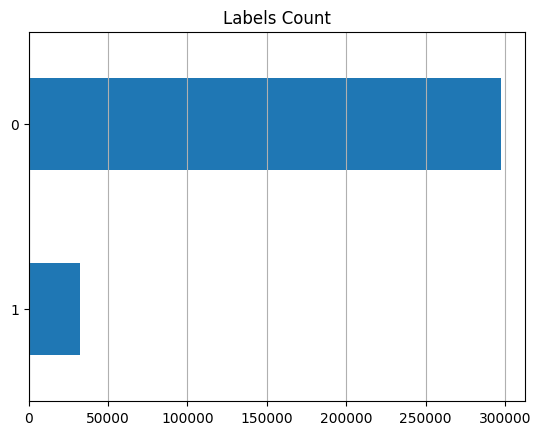

In [ ]:
ax = label_count.sort_values().plot(kind='barh', title='Labels Count')
ax.grid(axis="x")

### Part 1.2: Null value check

In [ ]:
model_all_data.isna().sum()

user_id                                     0
product_id                                  0
order_number                                0
order_dow                                   0
order_hour_of_day                           0
days_since_prior_order                  29995
user_product__total_orders                  0
user_product__add_to_cart_order_mean        0
user_product__reordered_mean                0
user_product__most_dow                      0
user_product__most_hod                      0
product__total_orders                       0
product__add_to_cart_order_mean             0
product__total_users                        0
product__reordered_mean                     0
product__most_dow                           0
product__most_hod                           0
product__days_since_prior_order_mean      726
user__order_count                           0
user__product_count                         0
user__days_since_prior_order_mean           0
user__reordered_mean              

### Part 1.3: Categorical Feature Transformation


In [ ]:
# One-hot encoding for the `product__department_id` feature.
model_all_data = pd.concat(
    [model_all_data.drop('product__department_id',axis=1),
     pd.get_dummies(model_all_data["product__department_id"],
                    prefix='product__department_id_')],
                     axis=1)

# Part 2: Split Dataset (Train, Validation and Test)

In order to do model training, model selection and evaluation, we split `model_all_data` to three datasets: train, validation, test.

In [ ]:
# We randomly select 20% users as test data.
# The remaining data will be used as train & validation data.
test_user_ids = model_all_data.user_id.drop_duplicates().sample(frac=0.2)
train_validation_data = model_all_data[~model_all_data.user_id.isin(test_user_ids)]
test_data = model_all_data[model_all_data.user_id.isin(test_user_ids)]

In [ ]:
print('Szie of original dataset before splitting: ', model_all_data.shape)
print('Size of train & validation dataset: ', train_validation_data.shape)
print('Size of test dataset: ', test_data.shape)

Szie of original dataset before splitting:  (329806, 47)
Size of train & validation dataset:  (263436, 47)
Size of test dataset:  (66370, 47)


# Part 3: Model Selection with Cross Validation

### Part 3.1: Model Selection with All Features

In [ ]:
train_validation_data_x = train_validation_data.drop(['user_id', 'product_id', 'label'],axis=1)
train_validation_data_y = train_validation_data['label']

In [ ]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ]

  # |--------------train-val(80)---------------| ---test(20)---|
  #  1      2       3         4         5
  #  1      2       3         4         5
  #  1      2       3         4         5
  #  1      2       3         4         5
  #  1      2       3         4         5


In [ ]:
def build_ml_pipeline(classifier):
  steps = list()
  steps.append(('fillnan', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)))
  steps.append(('downSample', RandomUnderSampler()))
  steps.append(('scaler', MinMaxScaler()))
  steps.append(('model', classifier))
  pipeline = Pipeline(steps=steps)
  return pipeline

In [ ]:
for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_data_x, train_validation_data_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')

CPU times: user 4.09 s, sys: 1.77 s, total: 5.86 s
Wall time: 4.16 s
LogisticRegression : F1 value is 34.415 (2.542)
CPU times: user 4.89 s, sys: 177 ms, total: 5.07 s
Wall time: 5.08 s
DecisionTreeClassifier : F1 value is 24.429 (1.141)
CPU times: user 49.1 s, sys: 301 ms, total: 49.4 s
Wall time: 55.7 s
RandomForestClassifier : F1 value is 33.318 (2.711)
CPU times: user 19.1 s, sys: 165 ms, total: 19.2 s
Wall time: 19.3 s
AdaBoostClassifier : F1 value is 34.017 (3.299)
CPU times: user 1min 19s, sys: 199 ms, total: 1min 19s
Wall time: 1min 20s
GradientBoostingClassifier : F1 value is 34.752 (3.363)


### Part 3.2: Feature Selection

In [ ]:
# Use all data - "train_validation_data_x" - recompute, no hyperparameter tuning。
# Select Gradient Boosting
pipeline = build_ml_pipeline(GradientBoostingClassifier())
pipeline.fit(train_validation_data_x, train_validation_data_y)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('scaler', MinMaxScaler()),
                ('model', GradientBoostingClassifier())])

In [ ]:
# Extract the feature importances from the trained model
importances = pipeline.steps[3][1].feature_importances_
feature_names=train_validation_data_x.columns.tolist()

In [ ]:
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances}).sort_values("importance", ascending=False)
top15_features = df_importances.head(15)

In [ ]:
# Only use the selected top 15 features in our training data.
train_validation_data_x_select_features = train_validation_data_x[top15_features['feature']]

In [ ]:
top15_features

,feature,importance
16,user__order_count,0.285727
6,user_product__reordered_mean,0.277687
4,user_product__total_orders,0.238420
0,order_number,0.073705
12,product__reordered_mean,0.069017
19,user__reordered_mean,0.018187
9,product__total_orders,0.007579
3,days_since_prior_order,0.006107
17,user__product_count,0.004637
18,user__days_since_prior_order_mean,0.004095


### Part 3.3: Train Neural Network Model

In [ ]:
# Feed forward neural network
def create_model():
    model = keras.Sequential([
        ### layer input
        keras.layers.Dense(30, input_dim=15, activation='relu'),
        ###  layer 1
        keras.layers.Dense(15, activation='relu'),
        ###  layer 2
        keras.layers.Dense(5, activation='relu'),
        ### layer output
        keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [ ]:
# wrap the model using the function you created
NN_model = KerasClassifier(build_fn=create_model, epochs=64, batch_size=32, verbose=0)

In [ ]:
keras_model = create_model()

In [ ]:
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                480       
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dense_2 (Dense)             (None, 5)                 80        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,031
Trainable params: 1,031
Non-trainable params: 0
_________________________________________________________________
None


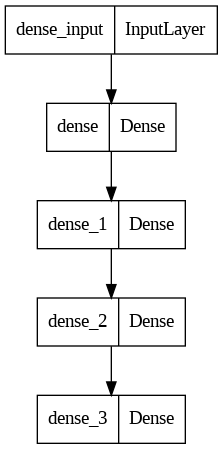

In [ ]:
plot_model(keras_model)

### Part 3.4: Model Selection with Selected Top 15 Features including Neural Network Model

In [ ]:
# Add our neural network model to our classifiers list.
classifiers.append(NN_model)

In [ ]:
for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_data_x_select_features, train_validation_data_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')




CPU times: user 1.97 s, sys: 1.1 s, total: 3.07 s
Wall time: 1.71 s
LogisticRegression : F1 value is 34.431 (2.414)
CPU times: user 2.91 s, sys: 146 ms, total: 3.06 s
Wall time: 3 s
DecisionTreeClassifier : F1 value is 24.584 (1.248)
CPU times: user 43.1 s, sys: 185 ms, total: 43.3 s
Wall time: 43.4 s
RandomForestClassifier : F1 value is 33.059 (2.675)
CPU times: user 13 s, sys: 81.3 ms, total: 13.1 s
Wall time: 13.6 s
AdaBoostClassifier : F1 value is 34.248 (3.176)
CPU times: user 51.2 s, sys: 99.4 ms, total: 51.3 s
Wall time: 52.1 s
GradientBoostingClassifier : F1 value is 34.674 (3.068)
1647/1647 [==============================] - 1s 784us/step
CPU times: user 7min 28s, sys: 22.7 s, total: 7min 51s
Wall time: 6min 49s
KerasClassifier : F1 value is 35.306 (0.641)


# Part 4: Hyper-parameter tuning for GradientBoostingClassifier

**Note: Due to the limitations of the computing power of the google colab platform, we only use 5% of the raw data here for hyper-paremter tuning.**

In [ ]:
# optional
sample_user_ids = train_validation_data.user_id.drop_duplicates().sample(frac=0.05)
train_validation_data_sample = train_validation_data[train_validation_data.user_id.isin(sample_user_ids)]

In [ ]:
train_validation_data_sample_x = train_validation_data_sample.drop(['user_id', 'product_id', 'label'],axis=1)[top15_features['feature']]
train_validation_data_sample_y = train_validation_data_sample['label']

In [ ]:
param_grid = {
    'model__n_estimators': [100,150],
    'model__max_depth': [4,6],
    'model__min_samples_split': [2,4,6],
    'model__learning_rate': [0.005, 0.01],
}

In [ ]:
grid = GridSearchCV(build_ml_pipeline(GradientBoostingClassifier()), cv=5, param_grid=param_grid, scoring='f1')
grid.fit(train_validation_data_sample_x, train_validation_data_sample_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fillnan',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('downSample', RandomUnderSampler()),
                                       ('scaler', MinMaxScaler()),
                                       ('model',
                                        GradientBoostingClassifier())]),
             param_grid={'model__learning_rate': [0.005, 0.01],
                         'model__max_depth': [4, 6],
                         'model__min_samples_split': [2, 4, 6],
                         'model__n_estimators': [100, 150]},
             scoring='f1')

In [ ]:
print("Best F1 value is %.3f" % grid.best_score_)
print("Params are %s" % grid.best_params_)

Best F1 value is 0.308
Params are {'model__learning_rate': 0.005, 'model__max_depth': 4, 'model__min_samples_split': 2, 'model__n_estimators': 150}


# Part 5: Train the final GradientBoostingClassifier

### Train the final model with all training+validation data and the best hyper-parameters.

In [ ]:
pipeline = build_ml_pipeline(GradientBoostingClassifier(
    n_estimators=100,
    min_samples_split=2,
    max_depth=4,
    learning_rate=0.005,
))

pipeline.fit(train_validation_data_x_select_features, train_validation_data_y)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('scaler', MinMaxScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.005, max_depth=4))])

In [ ]:
importances = pipeline.steps[3][1].feature_importances_
feature_names=train_validation_data_x_select_features.columns.tolist()
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances}).sort_values("importance", ascending=False)
df_importances.head(15)

,feature,importance
2,user_product__total_orders,0.360553
0,user__order_count,0.295372
1,user_product__reordered_mean,0.287069
4,product__reordered_mean,0.029280
3,order_number,0.026980
6,product__total_orders,0.000739
9,user__days_since_prior_order_mean,0.000008
5,user__reordered_mean,0.000000
7,days_since_prior_order,0.000000
8,user__product_count,0.000000


# Part 6: Model Evaluation

### Part 6.1: Predict product reorder on Test Data

In [ ]:
test_data_x_selected_features = test_data.drop(['user_id', 'product_id', 'label'],axis=1)[top15_features['feature']]
test_data_y = test_data['label']

In [ ]:
predict_y = pipeline.predict(test_data_x_selected_features)

In [ ]:
df_output = pd.DataFrame(
    {"user_id":test_data.user_id, "product_id":test_data.product_id, "predict":predict_y, "label":test_data.label})

In [ ]:
df_output.head()

,user_id,product_id,predict,label
1328,135743,30597,0,0
1329,135743,29471,0,0
1330,135743,44632,0,1
1331,135743,21709,1,1
1332,135743,20682,0,0


In [ ]:
predict_y_prob = pipeline.predict_proba(test_data_x_selected_features)[:,1]

### Part 6.2: Analyze classification result

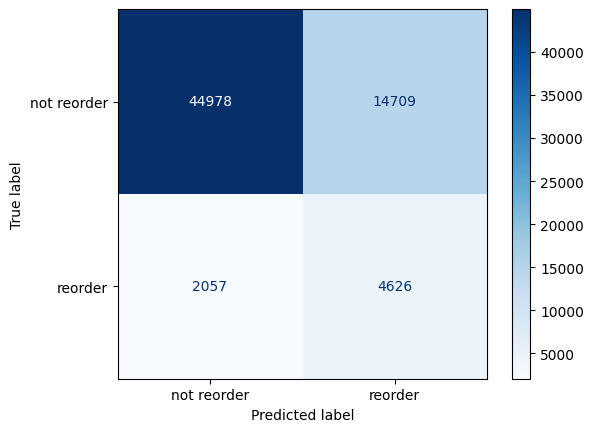

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline, test_data_x_selected_features, test_data_y,
                      display_labels=["not reorder","reorder"],cmap=plt.cm.Blues)

In [ ]:
acc = accuracy_score(test_data_y, predict_y)
f1 = f1_score(test_data_y, predict_y)
pre = precision_score(test_data_y, predict_y)
rec = recall_score(test_data_y, predict_y)
auc = roc_auc_score(test_data_y, predict_y_prob)

In [ ]:
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 35.5600%
ROC AUC : 79.9102%
Accuracy : 74.7386%
Precision : 23.9255%
Recall : 69.2204%


There is room for improvement in terms of precision and recall, as they are relatively low compared to the other metrics. Depending on the specific requirements and goals of the recommendation system, these results may need to be further analyzed and optimized to achieve the desired level of performance.